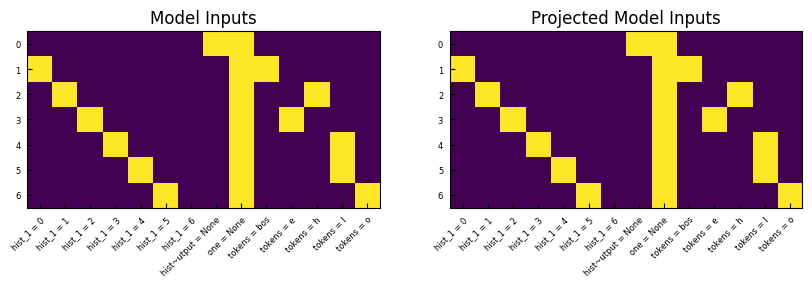

<Figure size 640x480 with 0 Axes>

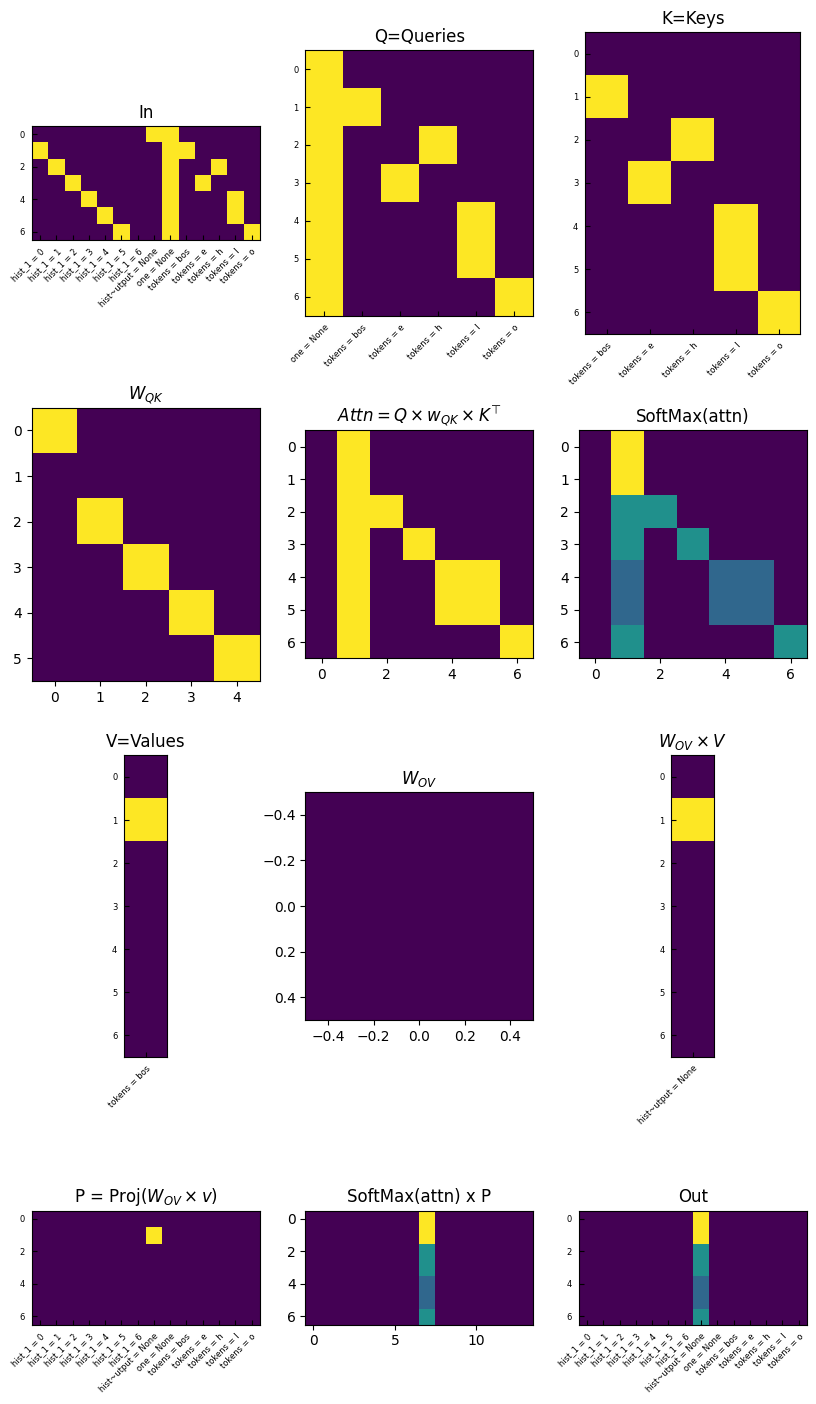

<Figure size 640x480 with 0 Axes>

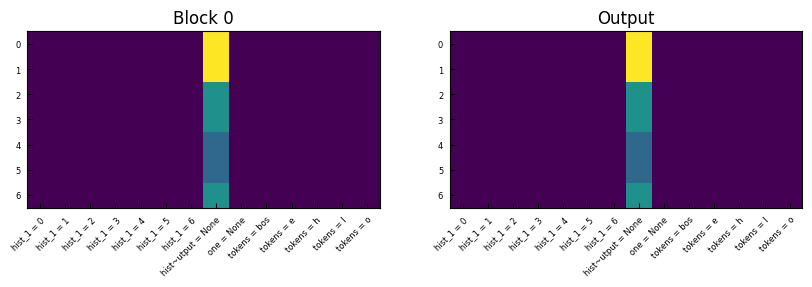

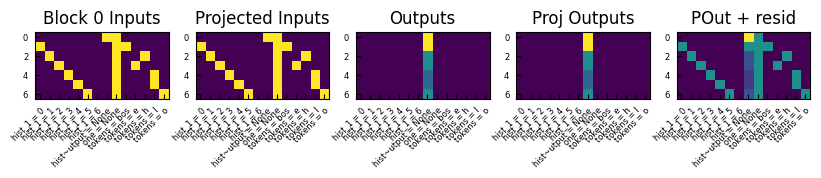

<Figure size 640x480 with 0 Axes>

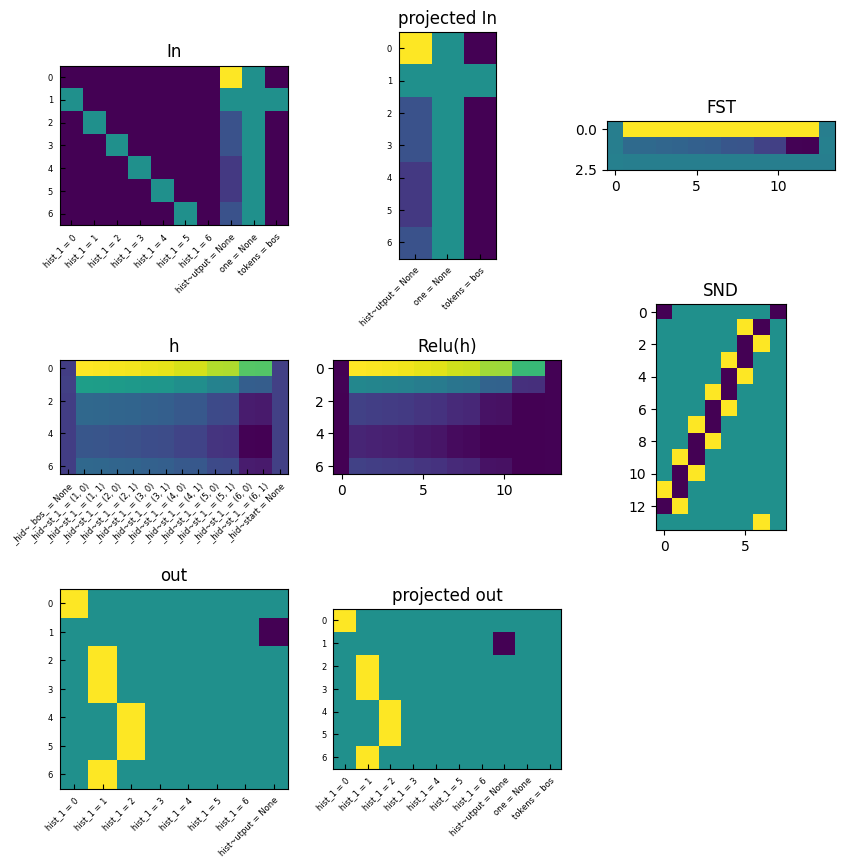

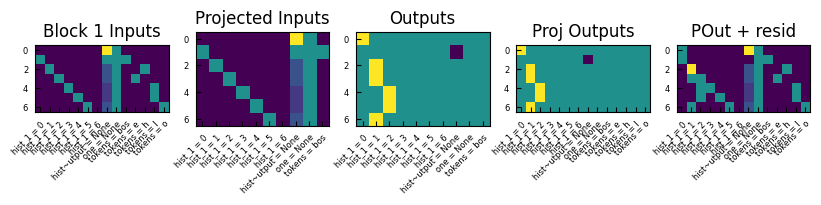

In [19]:
import tracr.craft.bases as bases

def make_mlp_verbose(mlp):
  def mlp_apply(self, x: bases.VectorInBasis) -> bases.VectorInBasis:
    from tracr.craft.vectorspace_fns import project
    from tracr.craft.transformers import relu

    assert x in self.residual_space
    plt.figure()
    fig, axs = plt.subplots(3,3, figsize=(10, 10))

    axs[0][0].set_title('In')
    axs[0][0].imshow(x.magnitudes)
    axs[0][0].set_xticks(np.arange(0, x.magnitudes.shape[1], 1.0))
    axs[0][0].set_xticklabels(format_basis_seq(x.basis_directions), rotation=45, ha='right', rotation_mode='anchor')
    axs[0][0].tick_params(axis="both", direction="in", pad=5, labelsize=6)

    x = project(self.residual_space, self.fst.input_space)(x)

    axs[0][1].set_title('projected In')
    axs[0][1].imshow(x.magnitudes)
    axs[0][1].set_xticks(np.arange(0, x.magnitudes.shape[1], 1.0))
    axs[0][1].set_xticklabels(format_basis(self.fst.input_space), rotation=45, ha='right', rotation_mode='anchor')
    axs[0][1].tick_params(axis="both", direction="in", pad=5, labelsize=6)

    hidden = self.fst(x)

    axs[0][2].set_title('FST')
    axs[0][2].imshow(self.fst.matrix)


    axs[1][0].set_title('h')
    axs[1][0].imshow(hidden.magnitudes)
    axs[1][0].set_xticks(np.arange(0, self.fst.matrix.shape[1], 1.0))
    axs[1][0].set_xticklabels(format_basis(self.fst.output_space), rotation=45,ha='right', rotation_mode='anchor')
    axs[1][0].tick_params(axis="both", direction="in", pad=5, labelsize=6)

    hidden = relu(hidden)

    axs[1][1].set_title('Relu(h)')
    axs[1][1].imshow(hidden.magnitudes)

    out = self.snd(hidden)
    axs[1][2].set_title('SND')
    axs[1][2].imshow(self.snd.matrix)

    axs[2][0].set_title('out')
    axs[2][0].imshow(out.magnitudes)
    axs[2][0].set_xticks(np.arange(0, self.snd.matrix.shape[1], 1.0))
    axs[2][0].set_xticklabels(format_basis(self.snd.output_space), rotation=45,ha='right', rotation_mode='anchor')
    axs[2][0].tick_params(axis="both", direction="in", pad=5, labelsize=6)

    

    projected = project(self.snd.output_space, self.residual_space)(out)
    axs[2][1].set_title('projected out')
    axs[2][1].imshow(projected.magnitudes)
    axs[2][1].set_xticks(np.arange(0, projected.magnitudes.shape[1], 1.0))
    axs[2][1].set_xticklabels(format_basis(self.residual_space), rotation=45, ha='right', rotation_mode='anchor')
    axs[2][1].tick_params(axis="both", direction="in", pad=5, labelsize=6)
    
    axs[2, 2].axis('off')
    
    #plt.tight_layout()
    plt.show()

    return projected

  from types import MethodType
  mlp.apply = MethodType( mlp_apply, mlp )



def make_attn_head_verbose(attn_head):
  def attn_apply(self, x: bases.VectorInBasis) -> bases.VectorInBasis:
      assert x in self.residual_space

      from tracr.craft.transformers import _np_softmax
      plt.figure()
      fig, axs = plt.subplots(4,3, figsize=(10, 18))

      axs[0][0].set_title('In')
      axs[0][0].imshow(x.magnitudes)
      axs[0][0].set_xticks(np.arange(0, x.magnitudes.shape[1], 1.0))
      axs[0][0].set_xticklabels(format_basis_seq(x.basis_directions), rotation=45, ha='right', rotation_mode='anchor')
      axs[0][0].tick_params(axis="both", direction="in", pad=5, labelsize=6)


      # seq_len x query_space
      queries = x.project(self.w_qk.left_space)

      axs[0][1].set_title('Q=Queries')
      axs[0][1].imshow(queries.magnitudes)
      axs[0][1].set_xticks(np.arange(0, queries.magnitudes.shape[1], 1.0))
      axs[0][1].set_xticklabels(format_basis(self.w_qk.left_space), rotation=45, ha='right', rotation_mode='anchor')
      axs[0][1].tick_params(axis="both", direction="in", pad=5, labelsize=6)


      # seq_len x key_space
      keys = x.project(self.w_qk.right_space)

      axs[0][2].set_title('K=Keys')
      axs[0][2].imshow(keys.magnitudes)
      axs[0][2].set_xticks(np.arange(0, keys.magnitudes.shape[1], 1.0))
      axs[0][2].set_xticklabels(format_basis(self.w_qk.right_space), rotation=45, ha='right', rotation_mode='anchor')
      axs[0][2].tick_params(axis="both", direction="in", pad=5, labelsize=6)

      axs[1][0].set_title('$W_{QK}$')
      axs[1][0].imshow(self.w_qk.matrix)


      attn_matrix = queries.magnitudes @ self.w_qk.matrix @ keys.magnitudes.T

      if self.causal:
        print("\n\n\n\nWarning this model has causal parameters that are not being displayed\n\n\n\n")
        # The 1 gives us the matrix above the diagonal.
        mask = np.triu(np.full_like(attn_matrix, -np.inf), 1)
        attn_matrix = attn_matrix + mask

      axs[1][1].set_title('$Attn=Q \\times w_{QK} \\times K^\\top$')
      axs[1][1].imshow(attn_matrix)

      attn_weights = _np_softmax(attn_matrix)  # seq_len_from, seq_len_to

      axs[1][2].set_title('SoftMax(attn)')
      axs[1][2].imshow(attn_weights)


      #projected_values = self.w_ov_residual(x)
      from tracr.craft.transformers import project
      x = project(self.residual_space, self.w_ov.input_space)(x)
      axs[2][0].set_title('V=Values')
      axs[2][0].imshow(x.magnitudes)
      axs[2][0].set_xticks(np.arange(0, x.magnitudes.shape[1], 1.0))
      axs[2][0].set_xticklabels(format_basis(self.w_ov.input_space), rotation=45, ha='right', rotation_mode='anchor')
      axs[2][0].tick_params(axis="both", direction="in", pad=5, labelsize=6)

      axs[2][1].set_title('$W_{OV}$')
      axs[2][1].imshow(self.w_ov.matrix)
      
      out = self.w_ov(x)
      
      axs[2][2].set_title('$W_{OV} \\times V$')
      axs[2][2].imshow(out.magnitudes)
      axs[2][2].set_xticks(np.arange(0, out.magnitudes.shape[1], 1.0))
      axs[2][2].set_xticklabels(format_basis_seq(out.basis_directions), rotation=45, ha='right', rotation_mode='anchor')
      axs[2][2].tick_params(axis="both", direction="in", pad=5, labelsize=6)


      projected_values = project(self.w_ov.output_space, self.residual_space)(out)

      values = projected_values.magnitudes  # seq_len_to, d_model
      axs[3][0].set_title('P = Proj($W_{OV} \\times v$)')
      axs[3][0].imshow(values)
      axs[3][0].set_xticks(np.arange(0, values.shape[1], 1.0))
      axs[3][0].set_xticklabels(format_basis_seq(projected_values.basis_directions), rotation=45, ha='right', rotation_mode='anchor')
      axs[3][0].tick_params(axis="both", direction="in", pad=5, labelsize=6)


      magnitudes = attn_weights @ values  # seq_len_from, d_model

      axs[3][1].set_title('SoftMax(attn) x P')
      axs[3][1].imshow(magnitudes)
      # axs[3][1].set_xticks(np.arange(0, values.shape[1], 1.0))
      # axs[3][1].set_xticklabels(format_basis_seq(projected_values.basis_directions), rotation=45, ha='right', rotation_mode='anchor')
      # axs[3][1].tick_params(axis="both", direction="in", pad=5, labelsize=6)

      ret = bases.VectorInBasis(sorted(self.residual_space.basis), magnitudes)

      axs[3][2].set_title('Out')
      axs[3][2].imshow(ret.magnitudes)
      axs[3][2].set_xticks(np.arange(0, ret.magnitudes.shape[1], 1.0))
      axs[3][2].set_xticklabels(format_basis_seq(ret.basis_directions), rotation=45, ha='right', rotation_mode='anchor')
      axs[3][2].tick_params(axis="both", direction="in", pad=5, labelsize=6)

      return ret
  from types import MethodType
  attn_head.apply = MethodType( attn_apply, attn_head )

def plot_basis_dir(ax, var, title):
  ax.set_title(title)
  ax.imshow(var.magnitudes)
  ax.set_xticks(np.arange(0, var.magnitudes.shape[1], 1.0))
  ax.set_xticklabels(format_basis_seq(var.basis_directions), rotation=45, ha='right', rotation_mode='anchor')
  ax.tick_params(axis="both", direction="in", pad=5, labelsize=6)

def make_multi_attention_head_verbose(multi_attn_head):
  def multi_apply(self, x: bases.VectorInBasis) -> bases.VectorInBasis:
      # each element is seq_len x embedding
      outs = [block.apply(x) for block in self.sub_blocks]
      ret = bases.VectorInBasis.sum(outs)  # seq_len x embedding
      plt.figure()
      fig, axs = plt.subplots(1, len(self.sub_blocks)+1, figsize=(10, 5))
      for i, out in enumerate(outs):
        plot_basis_dir(axs[i], out, f'Block {i}')

      plot_basis_dir(axs[-1], ret, f'Output')
      plt.show()
      return ret

  from types import MethodType
  multi_attn_head.apply = MethodType( multi_apply, multi_attn_head )
  for block in multi_attn_head.sub_blocks:
    make_attn_head_verbose(block)

def make_craft_model_verbose(craft_model):
  def model_apply(self, x: bases.VectorInBasis) -> bases.VectorInBasis:
      fig, axs = plt.subplots(1, 2, figsize=(10, 5))
      plot_basis_dir(axs[0], x, 'Model Inputs')
      x = x.project(self.residual_space)
      plot_basis_dir(axs[1], x, 'Projected Model Inputs')
      plt.show()
      for i, block in enumerate(self.blocks):
        
        x_in = x.project(block.residual_space)
        
        x_out = block.apply(x_in)
        
        proj_x_out = x_out.project(self.residual_space)

        fig, axs = plt.subplots(1, 5, figsize=(10, 5))
        plot_basis_dir(axs[0], x, f'Block {i} Inputs')
        plot_basis_dir(axs[1], x_in, f'Projected Inputs')
        plot_basis_dir(axs[2], x_out, f'Outputs')
        plot_basis_dir(axs[3], proj_x_out, f'Proj Outputs')
        x = x + proj_x_out
        plot_basis_dir(axs[4], x, f'POut + resid')
        plt.show()
      return x
  from types import MethodType
  craft_model.apply = MethodType( model_apply, craft_model )

  from tracr.craft.transformers import MultiAttentionHead, MLP
  for block in craft_model.blocks:
    if isinstance(block, MultiAttentionHead):
      make_multi_attention_head_verbose(block)
    elif isinstance(block, MLP):
      make_mlp_verbose(block)
    else:
      raise NotImplementedError()

# make_attn_head_verbose(craft_model.blocks[0].sub_blocks[0])
# make_multi_attention_head_verbose(craft_model.blocks[0])
# make_mlp_verbose(craft_model.blocks[1])

make_craft_model_verbose(craft_model)

input_space = craft_model.residual_space

_BOS_DIRECTION = input_space.basis[7].name
_ONE_DIRECTION = input_space.basis[8].name


def _make_input_space(vocab, max_seq_len):
  tokens_space = bases.VectorSpaceWithBasis.from_values("tokens", vocab)
  indices_space = bases.VectorSpaceWithBasis.from_values(
      "indices", range(max_seq_len))
  one_space = bases.VectorSpaceWithBasis.from_names([_ONE_DIRECTION])
  bos_space = bases.VectorSpaceWithBasis.from_names([_BOS_DIRECTION])
  input_space = bases.join_vector_spaces(tokens_space, indices_space, one_space,
                                         bos_space)

  return input_space


def _embed_input(input_seq, input_space):
  bos_vec = input_space.vector_from_basis_direction(
      bases.BasisDirection(_BOS_DIRECTION))
  one_vec = input_space.vector_from_basis_direction(
      bases.BasisDirection(_ONE_DIRECTION))
  embedded_input = [bos_vec + one_vec]
  for i, val in enumerate(input_seq):
    i_vec = input_space.vector_from_basis_direction(
        bases.BasisDirection("hist_1", i))
    val_vec = input_space.vector_from_basis_direction(
        bases.BasisDirection("tokens", val))
    embedded_input.append(i_vec + val_vec + one_vec)
  return bases.VectorInBasis.stack(embedded_input)



embedded_input = _embed_input(formatted_input, input_space=input_space)

output_seq = craft_model.apply(embedded_input)